# Systematic analysis of biases applied on NFB ADHD

This method takes advantage of studies technical and methodological high heterogeneity rather than suffering from it. Indeed, the domain of Neurofeedback (NFB) applied to ADHD children is characterized by a clinical litterature that is tremendously heterogeneous. Since we supposed that the methodologcial and technical choices made by authors may impact the efficay of NFB, we propose here to identify which of the factors independently influence the reported within-subject effect size (wES) thanks to adequate statistical tools (weighted least squares, regularization LASSO and a decision tree). See *Bussalb et al., 2019*.

## Import raw data

If you have not installed the ```source_assess_treatment_efficacy``` package (see ```README.md```) do not forget to uncomment and change the path given in ```sys.path.append```. It corresponds to the path where the modules are. Besides, make sure the requirements noted in ```requirements.txt``` are fulfilled. The csv file containing all required information (*values_total_all_factors_saob.csv*) is available. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
import random
import sys

from IPython.display import display

# Add the path where the packages are
sys.path.append(r"C:\Users\Aurore Bussalb\Desktop\github_repo\meta-analysis-statistical-tools\source_assess_treatment_efficacy")
import systematic_analysis_of_biases.import_csv_for_factors as icf
import systematic_analysis_of_biases.perform_saob as saob

%matplotlib inline

# Import data from a csv file
df_parents, df_teachers = icf.import_csv('values_total_all_factors_saob.csv')
df = pd.concat([df_parents, df_teachers])

C:\Users\Aurore Bussalb\Programing\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Compute the within Effect Size

In [2]:
# Cohen J. (1988). Statistical Power Analysis for the Behavioral Sciences
df['effect_size_treatment'] = df[['mean_post_test_treatment','mean_pre_test_treatment',
                                  'std_post_test_treatment','std_pre_test_treatment']
                                ].apply(lambda row:saob.effect_size_within_subjects(**row), axis=1) 

## Detect and reject within Effect Size outliers.

We plot the distribution of the wES before the rejection of outliers with the thresholds of acceptance (in black).

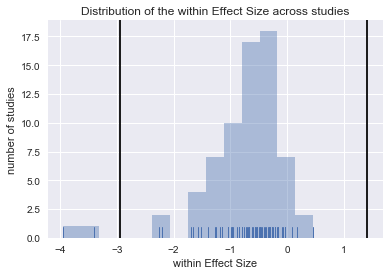

In [3]:
# Threshold of acceptance
mean_wES = df['effect_size_treatment'].mean()
std_wES = df['effect_size_treatment'].std()

bound_inf = mean_wES - 3*std_wES
bound_sup = mean_wES + 3*std_wES

# Detect outliers
plt.figure()  
sns.distplot(df['effect_size_treatment'].values, kde=False, rug=True)
plt.xlabel('within Effect Size')
plt.ylabel('number of studies')  
plt.title('Distribution of the within Effect Size across studies')  
plt.axvline(x=bound_inf, color='black') 
plt.axvline(x=bound_sup, color='black')

We then detect and reject the wES thtat are out of the bounds.

In [4]:
df, df['effect_size_treatment'] = saob.detect_and_reject_outliers(df, df['effect_size_treatment'])

Two outliers are identified and so rejected.

## Preprocess factors

We compute the wES (Cohen, 1988) for each clinical scale available in the articles included in the analysis. 

The pre-processing of factors for the analysis includes the following steps: factors for which there are too many missing observations, arbitrarily set to more than 20% of the total of observations, are removed from the analysis. Furthermore, if a factor has more than 80% similar observations it is removed as well. Categorical variables are coded as dummies meaning that the presence of the factor is represented by a 1 and its absence by 0. All variables are standardized, except when the decision tree is performed.

In [5]:
X, X_non_standardized = saob.preprocess_factors(df)

The type of thresholding, the use of a transfer card, the protocol beta up in frontal areas, the EEG quality equal to 3, the individualisation of frequency bands, coupling NFB with EMG-Biofeedback, and the presence of a control group are removed from the analysis.,

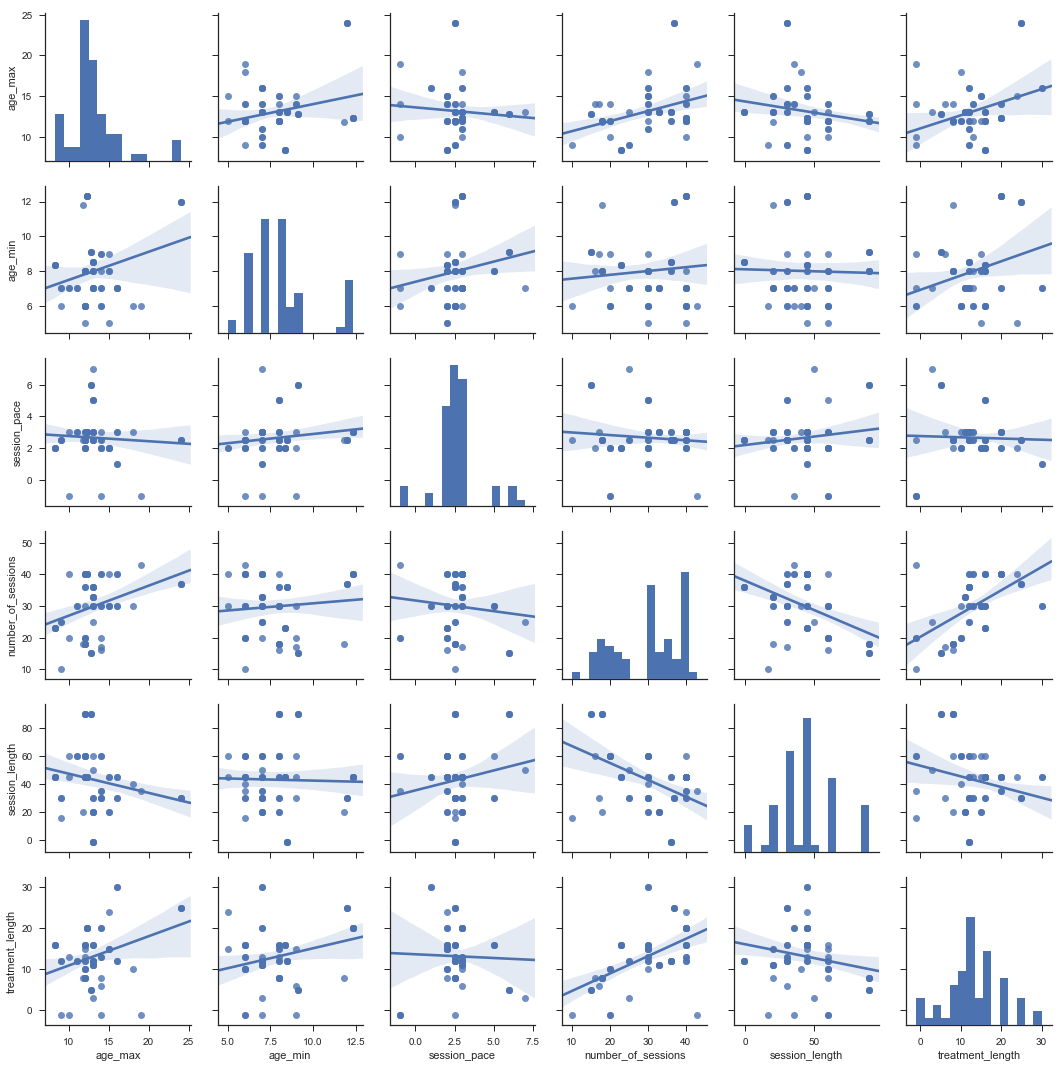

In [6]:
# Correlation plot between continuous variables
X_continuous_variables = X_non_standardized[['age_max', 'age_min', 'session_pace', 'number_of_sessions', 
                                      'session_length', 'treatment_length']] 
plt.figure()
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(X_continuous_variables, kind = "reg", diag_kws=dict(bins=15))    

Continuous variables seem not correlated.

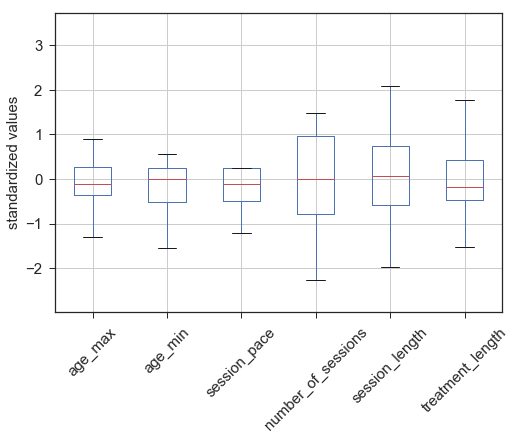

In [7]:
# Boxplots to assess the spread of the factors 
plt.figure()
ax = X.boxplot(['age_max', 'age_min', 'session_pace', 'number_of_sessions', 'session_length',
                'treatment_length'], fontsize=15, rot=45)
ax.set_ylabel('standardized values', fontsize=15)

Number of sessions, session and treatment length are more variable across studies than the age of included children and session space. 

In order to prevent any bias, it is possible to hide factor names during the analysis: 

In [8]:
# Run this cell to hide variable names
# X.columns = random.sample(range(1, len(X.columns)+1), len(X.columns))
# X_non_standardized.columns = X.columns

## First method: Weighted Least Squares (WLS)

The aim of the WLS is to estimate the regression coefficients of a **linear** and **weighted** model. A significant coefficient (meaning significantly different from 0) indicates that the associated factor has probably an influence on NFB efficacy and the sign of the coefficient indicates the direction of the effect. 

In [9]:
# WLS
summary = saob.weighted_linear_regression(df, X, df['effect_size_treatment'])
display(summary)

Moment matrix is invertible


<class 'statsmodels.iolib.summary.Summary'>
"""
                              WLS Regression Results                             
=================================================================================
Dep. Variable:     effect_size_treatment   R-squared:                       0.727
Model:                               WLS   Adj. R-squared:                  0.616
Method:                    Least Squares   F-statistic:                     6.583
Date:                   Thu, 20 Dec 2018   Prob (F-statistic):           7.58e-08
Time:                           16:48:18   Log-Likelihood:                -26.371
No. Observations:                     67   AIC:                             92.74
Df Residuals:                         47   BIC:                             136.8
Df Model:                             19                                         
Covariance Type:               nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                     -0.6570      0.053    -12.509      0.000      -0.763      -0.551
number_of_sessions                        -0.3554      0.090     -3.955      0.000      -0.536      -0.175
age_min                                    0.0247      0.080      0.308      0.760      -0.137       0.187
age_max                                   -0.1251      0.069     -1.823      0.075      -0.263       0.013
session_pace                              -0.0580      0.059     -0.991      0.327      -0.176       0.060
session_length                            -0.3370      0.099     -3.402      0.001      -0.536      -0.138
treatment_length                           0.3498      0.085      4.102      0.000       0.178       0.521
more_than_one_active_electrode_yes        -0.1739      0.065     -2.685      0.010      -0.304      -0.044
pblind_yes                                 0.1213      0.059      2.065      0.044       0.003       0.240
SCP_yes                                   -0.0257      0.138     -0.187      0.853      -0.303       0.251
EEG_quality_two                           -0.1807      0.082     -2.200      0.033      -0.346      -0.015
on_drugs_yes                              -0.0907      0.085     -1.063      0.293      -0.262       0.081
amplitude_based_artifact_rejection_yes     0.0522      0.080      0.651      0.518      -0.109       0.213
theta_down_yes                             0.0431      0.121      0.355      0.724      -0.201       0.287
beta_up_central_yes                       -0.0926      0.119     -0.780      0.439      -0.331       0.146
SMR_yes                                    0.1015      0.066      1.541      0.130      -0.031       0.234
IRB_yes                                   -0.2518      0.090     -2.786      0.008      -0.434      -0.070
EOG_correction_or_rejection_yes           -0.3522      0.103     -3.413      0.001      -0.560      -0.145
randomization_yes                          0.1527      0.080      1.915      0.062      -0.008       0.313
transfer_phase_yes                         0.4386      0.107      4.115      0.000       0.224       0.653
==============================================================================
Omnibus:                        1.871   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.392   Jarque-Bera (JB):                1.338
Skew:                           0.337   Prob(JB):                        0.512
Kurtosis:                       3.154   Cond. No.                         8.74
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can rely on the WLS results, because the following assumptions are satisfied:
* The moment matrix is invertible, 
* There is no apparent correltion between the continuous independent variables,
* The fit is significant: ```prob(F-statistic) = 7.58e-08```,
* The residuals are normally distributed: ```skew = 0.337```, ```kurtosis = 3.154``` and the Omnibus test ```(prob(Omnibus) = 0.392)```. 

In order to assess the impact of the weights on the results, we compare the WLS results with those obtained with the Ordinary Least Squares (OLS).

In [10]:
# Run the OLS to compare results
summary_ols = saob.ordinary_linear_regression(X, df['effect_size_treatment'])
display(summary_ols)

Moment matrix is invertible


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     effect_size_treatment   R-squared:                       0.537
Model:                               OLS   Adj. R-squared:                  0.350
Method:                    Least Squares   F-statistic:                     2.874
Date:                   Thu, 20 Dec 2018   Prob (F-statistic):            0.00169
Time:                           16:48:25   Log-Likelihood:                -25.883
No. Observations:                     67   AIC:                             91.77
Df Residuals:                         47   BIC:                             135.9
Df Model:                             19                                         
Covariance Type:               nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                     -0.6768      0.052    -13.031      0.000      -0.781      -0.572
number_of_sessions                        -0.2456      0.100     -2.455      0.018      -0.447      -0.044
age_min                                    0.0312      0.085      0.368      0.715      -0.140       0.202
age_max                                   -0.0651      0.085     -0.765      0.448      -0.236       0.106
session_pace                              -0.0360      0.070     -0.513      0.610      -0.177       0.105
session_length                            -0.2604      0.108     -2.408      0.020      -0.478      -0.043
treatment_length                           0.2811      0.090      3.113      0.003       0.099       0.463
more_than_one_active_electrode_yes        -0.1058      0.076     -1.384      0.173      -0.260       0.048
pblind_yes                                 0.1396      0.057      2.446      0.018       0.025       0.254
SCP_yes                                    0.0219      0.151      0.145      0.885      -0.281       0.325
EEG_quality_two                           -0.1336      0.092     -1.451      0.153      -0.319       0.052
on_drugs_yes                              -0.1011      0.102     -0.988      0.328      -0.307       0.105
amplitude_based_artifact_rejection_yes    -0.0182      0.083     -0.220      0.827      -0.185       0.149
theta_down_yes                             0.0025      0.136      0.018      0.985      -0.272       0.277
beta_up_central_yes                       -0.0437      0.137     -0.318      0.752      -0.320       0.232
SMR_yes                                    0.1030      0.074      1.386      0.172      -0.047       0.252
IRB_yes                                   -0.1961      0.091     -2.160      0.036      -0.379      -0.013
EOG_correction_or_rejection_yes           -0.2754      0.139     -1.988      0.053      -0.554       0.003
randomization_yes                          0.1505      0.086      1.740      0.088      -0.024       0.324
transfer_phase_yes                         0.3925      0.132      2.985      0.004       0.128       0.657
==============================================================================
Omnibus:                        2.456   Durbin-Watson:                   2.219
Prob(Omnibus):                  0.293   Jarque-Bera (JB):                1.746
Skew:                           0.204   Prob(JB):                        0.418
Kurtosis:                       3.678   Cond. No.                         8.95
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Here again, the assumptions are satisfied.
Less factors are found significantly different from 0 with OLS.

## Second method: Least Absolute Shrinkage and Selection Operator (LASSO)

The second method is **linear** and incorporates **variable selection** in the linear model. A coefficient not set to zero must explain the model (so it may have an influence of NFB efficacy). The sign of the coefficient indicates the direction of the effect.

In [11]:
coeff, mse_test, alphas, alpha = saob.regularization_lassocv(X, df['effect_size_treatment'])
print('Tuning parameter found by CV', alpha)
display(coeff)     

Tuning parameter found by CV 0.0585499091013


,Factors,Coefficients
0,number_of_sessions,-0.000000
1,age_min,-0.000000
2,age_max,-0.000000
3,session_pace,-0.004330
4,session_length,-0.000000
5,treatment_length,0.065101
6,more_than_one_active_electrode_yes,-0.033250
7,pblind_yes,0.122354
8,SCP_yes,0.000000
9,EEG_quality_two,-0.032315


0.261846976319


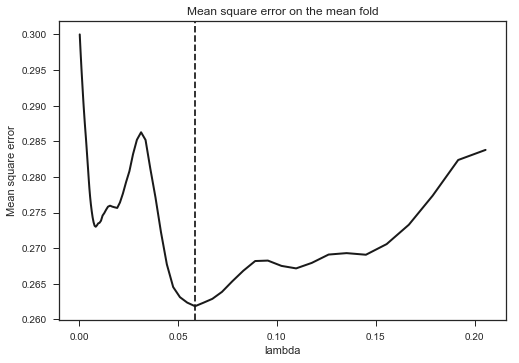

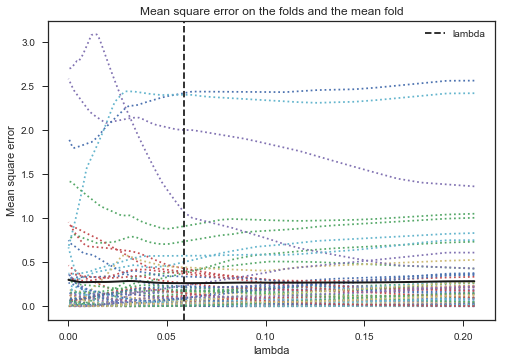

In [12]:
# Display results: see the better lambda
    
# MSE only on the mean fold
plt.figure()
plt.plot(alphas, mse_test.mean(axis=1),linewidth=2, color='k', label='lambda')
plt.axvline(alpha, linestyle='--', color='k', label='alpha: CV estimate')
plt.xlabel('lambda')
plt.ylabel('Mean square error')
plt.title('Mean square error on the mean fold')

test=mse_test.mean(axis=1)
print(test.min())
        
# MSE only on all the folds
plt.figure()
plt.plot(alphas, mse_test, ':')
plt.plot(alphas, mse_test.mean(axis=1),linewidth=2, color='k')
plt.axvline(alpha, linestyle='--', color='k', label='lambda')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('Mean square error')
plt.title('Mean square error on the folds and the mean fold')


Leave-one-out cross validation is applied to find the tuning parameter. The Mean Square Error (MSE) is computed on each test set. The tuning parameter correponds to the abscissa of the minimum value of the MSE on the mean fold. 

In [13]:
# Lasso with AIC criterion to compare results obtained with CV
coeff_aic = saob.regularization_lassoAIC(X, df['effect_size_treatment'])
display('Lasso results with AIC', coeff_aic) 

'Lasso results with AIC'

,Factors,Coefficients
0,number_of_sessions,-0.191332
1,age_min,0.000000
2,age_max,-0.031624
3,session_pace,-0.043257
4,session_length,-0.209865
5,treatment_length,0.237497
6,more_than_one_active_electrode_yes,-0.115109
7,pblind_yes,0.137665
8,SCP_yes,0.000000
9,EEG_quality_two,-0.122197


When we determine the tuning parameter with the AIC criterion, more factors have coefficients different from 0.

## Third method: Decision Tree

The last method used is the decision tree: a **hierarchical** and **non-linear** method.

In [14]:
# Decision tree
saob.decision_tree(X_non_standardized, df['effect_size_treatment'])

R² decision tree 0.319442201615
